# Logistic Regression


We will be dealing with logistic regression for classification, which is to identify which of the set of categories a new observation belongs to.


So far, we have seen regression problems where we try to predict a continuous value. Logistic Regression allows us to solve classification problems which involve discrete categories. Binary classes have either a value of 0 or 1 so a normal linear regression would not lead to a good fit. For logistic regression, we use a sigmoid function that takes in any value and outputs it to be between 0 and 1

For this session, we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a first step in machine learning! 

We'll be trying to predict a classification- survival or deceased.
Let's begin our understanding of implementing Logistic Regression in Python for classification.

We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.

## Import Libraries
Let's import some libraries to get started!

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [3]:
train = pd.read_csv('titanic_train.csv')
train.set_index('PassengerId', inplace=True)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


 Here we have:
 * A passanger ID
 * A Survived class which is either a 0 or 1 value for whether a person survived
 * A Pclass which is basically the passenger class (First, Second, Third)
 * SibSp is the number of siblings/spouses onboard
 * Parch is either the parent or children abord
 * Cabin if known
 * Embarked is the port of embarkment of the passenger

# Exploratory Data Analysis

Let's begin some exploratory data analysis! We'll start by checking out missing data!

## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

In [4]:
# Let's go ahead and see how we can check missing values in a data set.
train.isnull()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
887,False,False,False,False,False,False,False,False,False,True,False
888,False,False,False,False,False,False,False,False,False,False,False
889,False,False,False,False,True,False,False,False,False,True,False


<AxesSubplot:ylabel='PassengerId'>

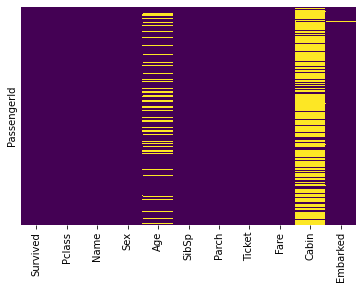

In [5]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with some form of imputation. Looking at the Cabin column, it looks like we are just missing too much of that data to do something useful with at a basic level. We'll probably drop this later, or change it to another feature like "Cabin Known: 1 or 0". We can also see that a single row in the embarked column is missing.

<AxesSubplot:xlabel='Survived', ylabel='count'>

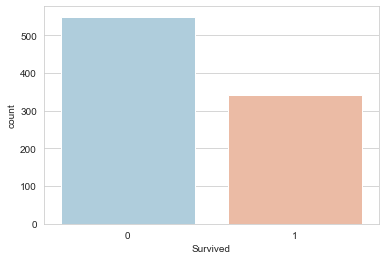

In [16]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

We can see here that about 500 people did not survive and 350 people did survived.

<AxesSubplot:xlabel='Survived', ylabel='count'>

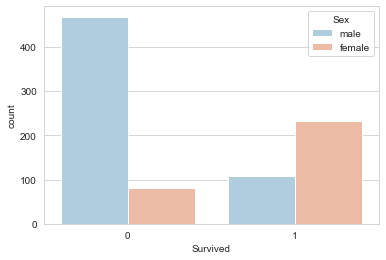

In [17]:
# Let us go ahead and add some hue here to understand this better 
sns.countplot(x='Survived',hue = 'Sex', data=train,palette='RdBu_r')

Looking at this plot we can analyse that the people that did not survive are mostly male and the people that did survive are almost twice as likely to be women. 
We will see more about the factors and coefficients of what led to someone's survival in a bit.

<AxesSubplot:xlabel='Survived', ylabel='count'>

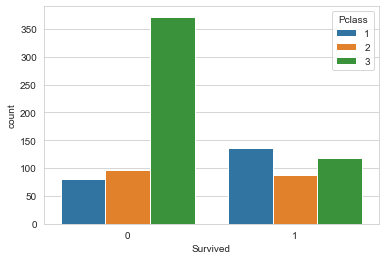

In [19]:
# Let us now go ahead and change the hue to Pclass
sns.countplot(x='Survived',hue = 'Pclass', data=train)

Looks like the people who did not survive are overwhelmingly belonging to the third class or the cheapest class to get onto. 

/Users/nidhisrinath/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age'>

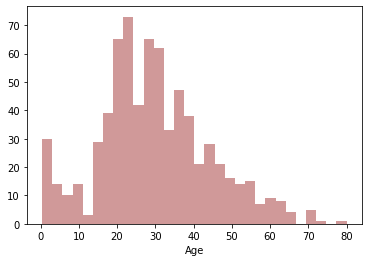

In [6]:
# Let us now see a distribution plot for the age.
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=30)

This plot is quite skewed to younger passengers. This is almost a bimodal distribution which has about two peaks. One under the age 10 and the peak around the age 20-30.

<AxesSubplot:ylabel='Frequency'>

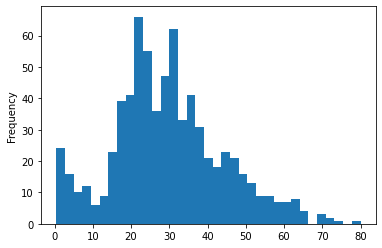

In [7]:
# Alternatively you can even plot this on pandas own visualisation
train['Age'].plot.hist(bins = 35)

In [23]:
# Lets now look into some other columns using the info method
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 115.8+ KB


<AxesSubplot:xlabel='SibSp', ylabel='count'>

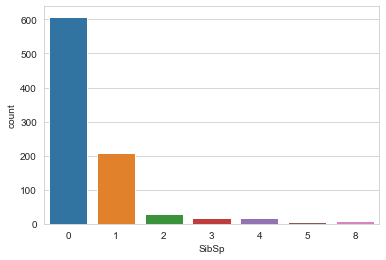

In [24]:
# Let us look into SibSp with the help of a countplot
sns.countplot(x='SibSp',data=train)

<AxesSubplot:>

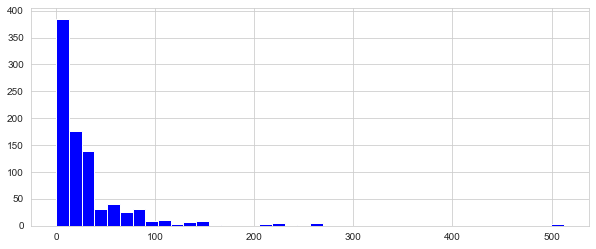

In [26]:
# Let us now look at the fare column
train['Fare'].hist(color='blue',bins=40,figsize=(10,4))

The fares are about 0 to 100 which makes sense considering how many people were on board from the 3rd class. These fares are from back when the titanic existed which is why they are also so low.

## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can be smarter about this and check the average age by passenger class. For example:

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

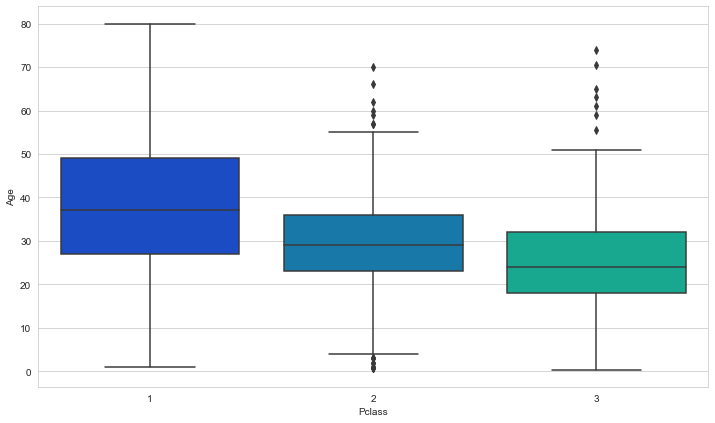

In [28]:
# Let us understand more about what this means using a boxplot
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

When we separate by class, the passengers on the 1st and 2nd class are older compared to the people on the 3rd class. We can use these average age according to the classes

In [8]:
# We can create a whole model that focuses on filling in the missing values for the age column
# But for now, let us use a function that does the imputation
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

Now let us go ahead and apply the function.

In [32]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
# We can now see how the data looks on applying the function

<AxesSubplot:ylabel='PassengerId'>

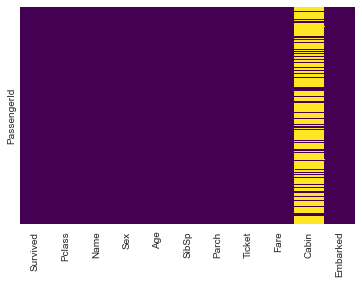

In [31]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Let's go ahead and drop the Cabin column and the row in Embarked that is NaN.

In [36]:
# UNCOMMENT THE BELOW STATEMENT
# train.drop('Cabin',axis=1,inplace=True)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [37]:
train.dropna(inplace=True)
# This ensures that we remove any missing values from the table

<AxesSubplot:ylabel='PassengerId'>

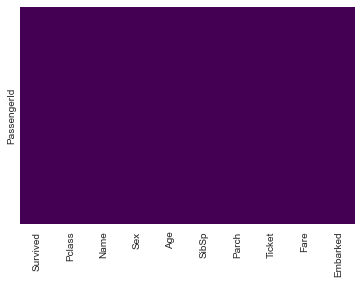

In [38]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Our data is now completely filled!

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables using pandas! Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    object 
 4   Age       889 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Ticket    889 non-null    object 
 8   Fare      889 non-null    float64
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.4+ KB


In [40]:
# Creating a dummy variable
# For instance the sex and embarked column is essentially just categories
# The ML Model cannot understand this so we create dummy variables

In [42]:
sex = pd.get_dummies(train['Sex'])
sex

,female,male
PassengerId,,
1,0,1
2,1,0
3,1,0
4,1,0
5,0,1
...,...,...
887,0,1
888,1,0
889,1,0


We can see that the values are now either just 0 or 1. But we still have a slight issue here. One column (Male or Female) acts as a perfect predictor for another column. This is an issue known as multicollinearity and it will mess up the columns. 

The model takes in the value 0 and assumes that it can predict perfectly for the other column

In [44]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
sex

,male
PassengerId,
1,1
2,0
3,0
4,0
5,1
...,...
887,1
888,0
889,0


So here this column is a representation of whether the person is male or female.

We will now do the same thing for the embark column

In [47]:
embark = pd.get_dummies(train['Embarked'],drop_first=True)
embark

,Q,S
PassengerId,,
1,0,1
2,0,0
3,0,1
4,0,1
5,0,1
...,...,...
887,0,1
888,0,1
889,0,1


In [49]:
# We'll now add these new columns into our dataframe
train = pd.concat([train,sex,embark],axis=1)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S,male,Q,S
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1,1,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0,0,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1,0,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1,0,0,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1,1,0,1


Now that we have our representative columns, we can go ahead and drop all the columns that we do not need.

In [50]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [51]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,male,Q,S
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1,1,0,1
2,1,1,38.0,1,0,71.2833,0,0,0,0,0,0
3,1,3,26.0,0,0,7.9250,0,0,1,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1,0,0,1
5,0,3,35.0,0,0,8.0500,1,0,1,1,0,1


In [53]:
# We can also drop the passenger ID columns as it is not really necessary
# UNCOMMENT THE NEXT LINE
# train.drop('PassengerId', axis =1, inplace = True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,male,Q,S
PassengerId,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,1,0,1,1,0,1
2,1,1,38.0,1,0,71.2833,0,0,0,0,0,0
3,1,3,26.0,0,0,7.9250,0,0,1,0,0,1
4,1,1,35.0,1,0,53.1000,0,0,1,0,0,1
5,0,3,35.0,0,0,8.0500,1,0,1,1,0,1


Our data is ready for our model!

# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=101)

## Training and Predicting

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/Users/nidhisrinath/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [58]:
predictions = logmodel.predict(X_test)

In [61]:
predictions

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1])

Let's move on to evaluate our model!

## Evaluation

We can check precision,recall,f1-score using classification report!

In [62]:
from sklearn.metrics import classification_report

In [63]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       163
           1       0.84      0.70      0.76       104

    accuracy                           0.83       267
   macro avg       0.83      0.81      0.82       267
weighted avg       0.83      0.83      0.83       267



Not so bad! You might want to explore other feature engineering and the other titanic_text.csv file, some suggestions for feature engineering: